# Counting, proofreading and visualizing inputs and outputs

This notebook requires an environment where the python <a href="https://navis.readthedocs.io/en/latest/" target="_blank">navis</a> and <a href="https://fafbseg-py.readthedocs.io/en/latest/source/api.html" target="_blank">fafbseq</a> packages are installed, apart from other well-known packages listed in the import below.
<br>**CONTAINS:**
<br>A) Analysis of inputs and ouputs based on *cleft score* value
<br>B) Analysis of inputs and outputs of a list of neurons
<br>C) Proofreading predicted synapses via annotations

#### Importing packages

In [1]:
#Importing packages
import navis
import fafbseg
from fafbseg import flywire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


#### Setting a "secret" for accessing data

To get your personal secret, please go to: <a href="https://fafbseg-py.readthedocs.io/en/latest/source/tutorials/flywire_secret.html" target="_blank">get my secret.</a>

In [ ]:
# fafbseg.flywire.set_chunkedgraph_secret("5719b2db462d94d6aa0e903c1ff889e4") # 2022.03.11
# fafbseg.flywire.set_chunkedgraph_secret("c161f679dd3d52b1d5fc19f62cdd0164") # 2022.04.11 
fafbseg.flywire.set_chunkedgraph_secret("0c0edb71c5682a971dbadc37bcbabf29") # 2022.06.21 

## A) Analysis of inputs and ouputs based on *cleft score* value

To automatically detect of pre- and postsynaptic sites, the algorithm used in <a href="https://www.nature.com/articles/s41592-021-01183-7" target="_blank">Buhman et al. 2021.</a>
<br>A visualization of all predicted synapses can visualized by Neuroglancer <a href="http://www.tinyurl.com/tdq6xkw" target="_blank">here.</a>
<br>The algorithm returns a list of connections with two scores: the cleft score and the connection score. Number of detected synapses depend on them.

<font size="4"> The *cleft score* matters, the *connection score* not that much:</font> <br/>
<span style="color:blue">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; True positives </span> <br/>
<span style="color:Chocolate">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; False positives </span> <br/>
<span style="color:DimGrey">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Unkown </span> <br/>


<img src="./Images/proofreading/szi-chieh_labels_synapse_eval_cleft_score.png" 
     alt="cleft_score"
     width="300" height="300" style="float: left ; width: 40%; padding-left: 10%"/>
<img src="./Images/proofreading/szi-chieh_labels_synapse_eval_synful_score.png" 
     alt="connection_score"
     width="300" height="300" style="float: left ; width: 40%; padding-left: 0%"/>



### Testing different cleft score values in Tm9 inputs

In the following cells, we choose different *cleft score* values to get the total number of inputs and outputs of a single Tm9.

In [ ]:
#Getting inputs and outputs for one neuron with different min_score values

# FIRST, Check if root IDs are outdated (i.e. have more recent edits)
r1 = 720575940626482442 # root ID query for Tm9
print(f'ID up-to-date in FlyWire: {flywire.is_latest_root([r1])}')
# SECOND, proceed getting the neurons data if the ID is up to date
if flywire.is_latest_root([r1])[0]:
    neuron = flywire.get_mesh_neuron(r1) # mesh query
else:
    print(f'ID not up to date. Update it and run again')

# THIRD, proceed getting the neuron's inputs and outputs for a list of different min_scores 
# “Cleft score” for automatic synaptic detection, Buhmann et al., 2021
if flywire.is_latest_root([r1])[0]:
    min_score_ls = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]
    in_count_ls =[]
    out_count_ls =[]
    pre_count_ls=[]
    post_count_ls=[]
    
    for score in min_score_ls:
        # Fetch the neuron's inputs and ouputs
        inputs = flywire.synapses.fetch_synapses(neuron, pre=False, post=True, attach=True, 
                                                 min_score=score, clean=True, transmitters=False, 
                                                 neuropils=True, live_query=True, batch_size=30, 
                                                 dataset='production', progress=True)
        outputs = flywire.synapses.fetch_synapses(neuron, pre=True, post=False, attach=True, 
                                                 min_score=score, clean=True, transmitters=False, 
                                                 neuropils=True, live_query=True, batch_size=30, 
                                                 dataset='production', progress=True)
        
        # Counting inputs and ouputs per ID
        inputs_count = {}
        inputs_str = inputs.applymap(str)
        for c in inputs_str['pre'].to_list():
            inputs_count[c] = inputs_count.get(c, 0) + 1
        input_count_df = pd.DataFrame(inputs_count, index=[0])
        input_count_df = input_count_df.T
        input_count_df.rename(columns={0: "counts"},inplace=True)
        input_count_df.index.names = ['presynaptic_ID']
        input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
        

        outputs_count = {}
        outputs_str = outputs.applymap(str)
        for c in outputs_str['post'].to_list():
            outputs_count[c] = outputs_count.get(c, 0) + 1
        output_count_df = pd.DataFrame(outputs_count, index=[0])
        output_count_df = output_count_df.T
        output_count_df.rename(columns={0: "counts"},inplace=True)
        output_count_df.index.names = ['postsynaptic_ID']
        output_count_df['presynaptic_ID'] = outputs_str['pre'].to_list()[0:len(output_count_df)]
        
        #Storing useful info during the for-loop
        in_count_ls.append(input_count_df['counts'].sum())
        out_count_ls.append(output_count_df['counts'].sum())
        pre_count_ls.append(len(input_count_df.index))
        post_count_ls.append(len(output_count_df.index))
        
        # Printing useful info
        #print(f"Current score = {score}")
        #print(f"Total number of inputs = {input_count_df['counts'].sum()}")
        #print(f"Total number of outputs = {output_count_df['counts'].sum()}")
        #print(f"Total number of presynaptic partners = {len(input_count_df.index)}")
        #print(f"Total number of postsynaptic partners = {len(output_count_df.index)}")

Let's now creat a pandas dataframe with the obtain lists and then generate some line plots.

In [ ]:
#Generation of pandas dataframe from lists
cleft_score_df = pd.DataFrame(list(zip(min_score_ls, in_count_ls, out_count_ls, pre_count_ls, post_count_ls)),
               columns =['Cleft_scores', 'input_count', 'output_count','pre_partner_count', 'post_partner_count'])
#print(cleft_score_df)

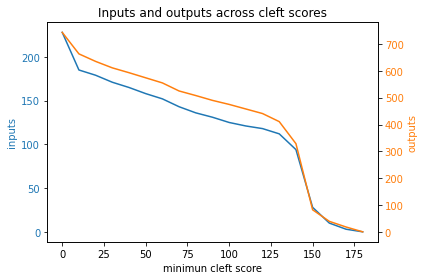

In [41]:
#Plotting
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.plot(cleft_score_df['Cleft_scores'],cleft_score_df['input_count'], color=color)
ax1.set_ylabel('inputs', color=color) 
ax1.set_title('Inputs and outputs across cleft scores')
ax1.set_xlabel('minimun cleft score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('outputs', color=color)  
ax2.plot(cleft_score_df['Cleft_scores'],cleft_score_df['output_count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# Saving excel files
# Setting variable
outDir = r'Z:\Connectomics data\FlyWire\Excels\min_score_50'
save_excel_file = False

if save_excel_file: 
    ## Inputs
    file_name = str(neuron.id)+'_inputs.xlsx'
    savePath = os.path.join(outDir, file_name)
    inputs_str = inputs.applymap(str)
    inputs_str.to_excel(savePath)

    file_name = str(neuron.id)+'_inputs_count.xlsx'
    savePath = os.path.join(outDir, file_name)
    input_count_str_df = input_count_df.applymap(str)
    input_count_str_df.to_excel(savePath)


    ## Outputs
    file_name = str(neuron.id)+'_outputs.xlsx'
    savePath = os.path.join(outDir, file_name)
    outputs_str = outputs.applymap(str)
    outputs_str.to_excel(savePath)

    file_name = str(neuron.id)+'_outputs_count.xlsx'
    savePath = os.path.join(outDir, file_name)
    output_count_str_df = output_count_df.applymap(str)
    output_count_str_df.to_excel(savePath)

## B) Analysis of inputs and outputs of a list of neurons

In [ ]:
# Check if root IDs are outdated (i.e. have more recent edits)
# Selecting Neurons
r1_ls = [720575940626482442,720575940637243738, 720575940638891683, 720575940607562251,720575940618719915,720575940633832287, 720575940618885205, 720575940612409571]   # root ID query
r1_ls = [720575940626482442,720575940637243738]   # root ID query
print(f'ID up-to-date in FlyWire: {flywire.is_latest_root(r1_ls)}')

In [ ]:
# Getting the meshes from FlyWire
if np.unique(flywire.is_latest_root(r1_ls))[0]:
    neurons = flywire.get_mesh_neuron(r1_ls) # mesh query
else:
    print(f'IDs not up to date, analysis aborted') 


if np.unique(flywire.is_latest_root(r1_ls))[0]:
    # Fetch the neuron's inputs and putputs
    neurons_inputs = flywire.synapses.fetch_synapses(neurons, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, live_query=True, batch_size=30, 
                                             dataset='production', progress=True)
    neurons_outputs = flywire.synapses.fetch_synapses(neurons, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, live_query=True, batch_size=30, 
                                             dataset='production', progress=True)
    #synaptic_counts = flywire.synapses.synapse_counts(root_ids, by_neuropil=False, min_score=30, live_query=True,batch_size=10, dataset='production')
    

#### Selecting a neuropile of interest for synaptic counts per neuron ID

In [ ]:
# Selecting inputs from a single neuropile
neuropile = 'ME_R' # String. 'LO_R', 'ME_R', ...
neuropile_neurons_inputs = neurons_inputs[neurons_inputs['neuropil'] == neuropile]

In [ ]:
# LOOPING. Counting inputs and ouputs per ID, option joining dataframes
final_input_df = pd.DataFrame()
for n in neuropile_neurons_inputs['post'].unique():
    inputs_count = {}
    curr_inputs = neuropile_neurons_inputs[neuropile_neurons_inputs['post'] == n]
    inputs_str = curr_inputs.applymap(str)
    
    for c in inputs_str['pre'].to_list():
        inputs_count[c] = inputs_count.get(c, 0) + 1
    input_count_df = pd.DataFrame(inputs_count, index=[0])
    input_count_df = input_count_df.T
    input_count_df.rename(columns={0: "counts"},inplace=True)
    input_count_df.index.names = ['presynaptic_ID']
    input_count_df = input_count_df.sort_values(by="counts",ascending=False)
    input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
    final_input_df = final_input_df.append(input_count_df)
    #print(f'Counting done for: {n}')
input_count_str_df = final_input_df.applymap(str)


In [ ]:
# Saving data in your computer
outDir = r'Z:\Connectomics data\FlyWire\Excels\min_score_50'
save_excel_file = False

if save_excel_file: 
    ## Input count
    file_name = f'All_neurons_input_count_{neuropile}.xlsx'
    savePath = os.path.join(outDir, file_name)
    input_count_str_df.to_excel(savePath)

## C) Proofreading predicted synapses via annotations


In [73]:
# Manually loading the URL containing synapses as annotations and notes in each

URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5833034053976064'
dict_URL = fafbseg.flywire.decode_url(URL)


In [116]:
# Loading the URLs from an excel file

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'All_Tm9_neurons_input_count_ME_R_20221017.xlsx'
filePath = os.path.join(dataPath,fileName)

df = pd.read_excel(filePath)

URL_ls = df['URL buhmann postsynapses']

#URL_ls =['https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5833034053976064','https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6635071146557440']

In [117]:
URL_ls

['https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5833034053976064',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6635071146557440']

In [111]:
# Extracting points and labels/descriptions
points = []
descriptions = []
segment_ids = []

for URL in URL_ls:
    dict_URL = fafbseg.flywire.decode_url(URL)
    for ann in dict_URL['annotations']:
        if 'point' in ann.keys():
            points.append(ann['point'])
            descriptions.append(ann['description'])
            segment_ids.append(ann['segments'])

            
# Splitting in pre and post IDs
pre = []
post = []
for pair in segment_ids:
    pre.append(pair[0])
    post.append(pair[1])   
    
#  len([d for d in descriptions if d.lower() == 'true' or d.lower() == 'true\n' ]) # Brief count of true synapses

In [112]:
# Creating the summary data frame
proofread_synapses_df = pd.DataFrame()

proofread_synapses_df['post_pt_position'] = points
proofread_synapses_df['proofread_label'] = descriptions
proofread_synapses_df['pre_id'] = pre
proofread_synapses_df['post_id'] = post
    

In [113]:
proofread_synapses_df.head()

,post_pt_position,proofread_label,pre_id,post_id
0,"[65992, 86783, 5371]",true,720575940631976403,720575940627738884
1,"[66561, 86438, 5313]",true?\n,720575940631976403,720575940627738884
2,"[65884, 86700, 5354]","not sure, versicles & psd yes",720575940631976403,720575940627738884
3,"[68806, 84922, 5363]",TRUE,720575940623818423,720575940627738884
4,"[68679, 84921, 5361]",TRUE,720575940623818423,720575940627738884
